In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,  accuracy_score, silhouette_score


import warnings
warnings.filterwarnings("ignore")

# DATA

In [95]:
data = pd.read_csv('/content/drive/MyDrive/BA - Project 2/Data/online_retail_II.csv')
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [97]:
data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [98]:
df = data.drop(["Description", "Country"], axis = 1)
df

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085.0
1,489434,79323P,12,2009-12-01 07:45:00,6.75,13085.0
2,489434,79323W,12,2009-12-01 07:45:00,6.75,13085.0
3,489434,22041,48,2009-12-01 07:45:00,2.10,13085.0
4,489434,21232,24,2009-12-01 07:45:00,1.25,13085.0
...,...,...,...,...,...,...
1067366,581587,22899,6,2011-12-09 12:50:00,2.10,12680.0
1067367,581587,23254,4,2011-12-09 12:50:00,4.15,12680.0
1067368,581587,23255,4,2011-12-09 12:50:00,4.15,12680.0
1067369,581587,22138,3,2011-12-09 12:50:00,4.95,12680.0


In [99]:
df.isnull().sum()

Invoice             0
StockCode           0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
dtype: int64

In [100]:
df.dropna(inplace=True)

In [101]:
df.drop(df[df.duplicated()].index, axis=0, inplace=True)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 797883 entries, 0 to 1067370
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      797883 non-null  object 
 1   StockCode    797883 non-null  object 
 2   Quantity     797883 non-null  int64  
 3   InvoiceDate  797883 non-null  object 
 4   Price        797883 non-null  float64
 5   Customer ID  797883 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 42.6+ MB


# New Feature

In [103]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

Drop row has quantity and price <=0

In [104]:
df= df[(df['Price'] > 0)]

In [105]:
df= df[(df['Quantity'] > 0)]

**Drop non-numeric stock**

In [106]:
# only non-numeric stock
wrong_stock_codes= df[df["StockCode"].astype(str).str.contains(r"^[a-zA-Z''-'\s]{1,40}$")]["StockCode"].unique().tolist()

df[df["StockCode"].isin(wrong_stock_codes)].groupby(["StockCode"]).agg({"StockCode": "count"})

,StockCode
StockCode,
ADJUST,32
BANK CHARGES,31
D,5
DOT,16
M,681
PADS,17
POST,1803


In [107]:
df= df[~df["StockCode"].isin(wrong_stock_codes)].reset_index(drop=True)

In [108]:
# other non-numeric stock (number+alphabet)
wrong_stock_codes2= df[df["StockCode"].astype(str).str.contains(r"[a-zA-Z]{3,}")]["StockCode"].unique().tolist()
df[df["StockCode"].isin(wrong_stock_codes2)].groupby(["StockCode"]).agg({"StockCode": "count"})

,StockCode
StockCode,
ADJUST2,3
TEST001,9
TEST002,1


In [109]:
df= df[~df["StockCode"].isin(wrong_stock_codes2)].reset_index(drop=True)

**convert the type of some column**

In [110]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [111]:
df["Customer ID"]= df["Customer ID"].astype('object')

In [112]:
df

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,TotalPrice
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085.0,83.40
1,489434,79323P,12,2009-12-01 07:45:00,6.75,13085.0,81.00
2,489434,79323W,12,2009-12-01 07:45:00,6.75,13085.0,81.00
3,489434,22041,48,2009-12-01 07:45:00,2.10,13085.0,100.80
4,489434,21232,24,2009-12-01 07:45:00,1.25,13085.0,30.00
...,...,...,...,...,...,...,...
776820,581587,22613,12,2011-12-09 12:50:00,0.85,12680.0,10.20
776821,581587,22899,6,2011-12-09 12:50:00,2.10,12680.0,12.60
776822,581587,23254,4,2011-12-09 12:50:00,4.15,12680.0,16.60
776823,581587,23255,4,2011-12-09 12:50:00,4.15,12680.0,16.60


# RFM Score

**Take 3 months of data, calculate RFM and use it for predicting next 6 months**

In [113]:
#create 3m and 6m dataframes
tx_3m = df[(df.InvoiceDate < datetime(2011, 6, 1)) & (df.InvoiceDate >= datetime(2011, 3, 1))].reset_index(drop=True)
tx_6m = df[(df.InvoiceDate >= datetime(2011, 6, 1)) & (df.InvoiceDate < datetime(2011, 12, 1))].reset_index(drop=True)

# Choose best number to cluster

In [114]:
tx_user = pd.DataFrame(df['Customer ID'].unique())
tx_user.columns = ['Customer ID']

tx_max_purchase = df.groupby('Customer ID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['Customer ID','MaxPurchaseDate']

tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

tx_user = pd.merge(tx_user, tx_max_purchase[['Customer ID','Recency']], on='Customer ID')

In [115]:
tx_user.Recency.describe()

count    5853.000000
mean      199.249103
std       208.528333
min         0.000000
25%        24.000000
50%        94.000000
75%       378.000000
max       738.000000
Name: Recency, dtype: float64

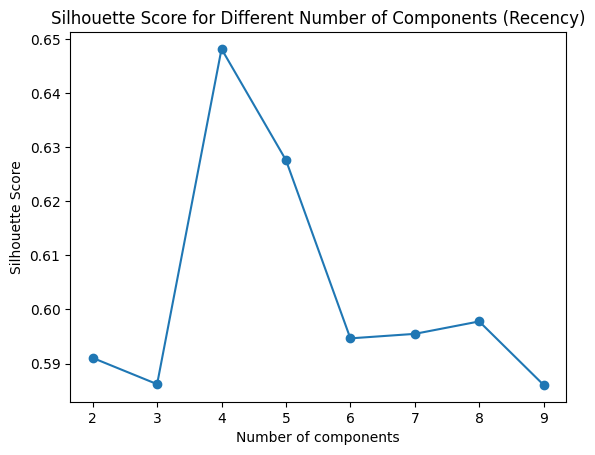

In [116]:
silhouette_scores = []

for k in range(2, 10):  # Số lượng cụm từ 2 đến 9
    gmm = GaussianMixture(n_components=k, max_iter=1000).fit(tx_user[['Recency']])
    labels = gmm.predict(tx_user[['Recency']])
    silhouette_scores.append(silhouette_score(tx_user[['Recency']], labels))

plt.figure()
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Components (Recency)')
plt.show()

In [117]:
tx_user = pd.DataFrame(df['Customer ID'].unique())
tx_user.columns = ['Customer ID']
tx_frequency = df.groupby('Customer ID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['Customer ID','Frequency']

tx_user = pd.merge(tx_user, tx_frequency, on='Customer ID')

In [118]:
tx_user.Frequency.describe()

count     5853.000000
mean       132.722535
std        342.136118
min          1.000000
25%         21.000000
50%         52.000000
75%        138.000000
max      12425.000000
Name: Frequency, dtype: float64

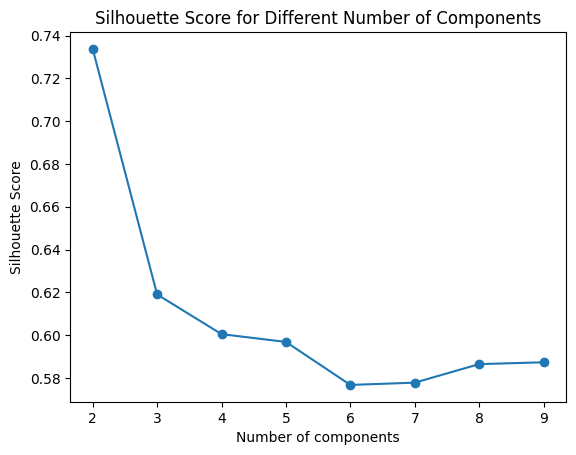

In [119]:
silhouette_scores = []

for k in range(2, 10):  # Số lượng cụm từ 2 đến 9
    gmm = GaussianMixture(n_components=k, max_iter=1000).fit(tx_user[['Frequency']])
    labels = gmm.predict(tx_user[['Frequency']])
    silhouette_scores.append(silhouette_score(tx_user[['Frequency']], labels))

plt.figure()
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Components')
plt.show()

In [120]:
tx_user = pd.DataFrame(df['Customer ID'].unique())
tx_user.columns = ['Customer ID']

tx_3m['Revenue'] = tx_3m['Price'] * tx_3m['Quantity']
tx_revenue = tx_3m.groupby('Customer ID').Revenue.sum().reset_index()

tx_user = pd.merge(tx_user, tx_revenue, on='Customer ID')

In [121]:
tx_user.Revenue.describe()

count     1991.000000
mean       853.012742
std       2241.241102
min          2.900000
25%        225.755000
50%        393.600000
75%        814.830000
max      52454.100000
Name: Revenue, dtype: float64

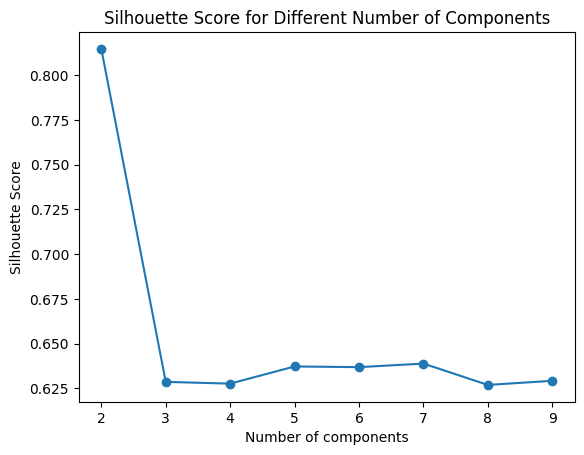

In [122]:
silhouette_scores = []

for k in range(2, 10):  # Số lượng cụm từ 2 đến 9
    gmm = GaussianMixture(n_components=k, max_iter=1000).fit(tx_user[['Revenue']])
    labels = gmm.predict(tx_user[['Revenue']])
    silhouette_scores.append(silhouette_score(tx_user[['Revenue']], labels))

plt.figure()
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Components')
plt.show()

# 3 cluster is optimal

In [123]:
tx_user = pd.DataFrame(df['Customer ID'].unique())
tx_user.columns = ['Customer ID']

# Define a function to order clusters
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index": cluster_field_name})
    return df_final

#calculate recency score
tx_max_purchase = tx_3m.groupby('Customer ID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['Customer ID','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['Customer ID','Recency']], on='Customer ID')

gmm = GaussianMixture(n_components=2)
gmm.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = gmm.predict(tx_user[['Recency']])

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

#calcuate frequency score
tx_frequency = tx_3m.groupby('Customer ID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['Customer ID','Frequency']
tx_user = pd.merge(tx_user, tx_frequency, on='Customer ID')

gmm = GaussianMixture(n_components=2)
gmm.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = gmm.predict(tx_user[['Frequency']])

tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#calcuate revenue score
tx_3m['Revenue'] = tx_3m['Price'] * tx_3m['Quantity']
tx_revenue = tx_3m.groupby('Customer ID').Revenue.sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='Customer ID')

gmm = GaussianMixture(n_components=2)
gmm.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = gmm.predict(tx_user[['Revenue']])
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)


#overall scoring
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']


In [124]:
tx_user.groupby('OverallScore')[['Recency','Frequency','Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,60.221469,22.108475,367.390237
1,17.389831,31.361582,621.742486
2,12.699301,92.769231,2846.399650
3,10.320513,211.512821,5332.445641


0 to 2: Low Value

3 to 4: Mid Value

5: High Value


# Overall Score

In [125]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>0,'Segment'] = 'Mid-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'High-Value'


In [126]:
tx_user.head()

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,13078.0,8,1,97,1,2472.85,1,3,High-Value
1,12682.0,0,1,101,1,2095.15,1,3,High-Value
2,13767.0,11,1,103,1,3097.47,1,3,High-Value
3,15311.0,4,1,495,1,16692.66,1,3,High-Value
4,14911.0,5,1,1074,1,21081.80,1,3,High-Value


**calculate 6 months LTV for each customer**

In [127]:
tx_6m['Revenue'] = tx_6m['Price'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('Customer ID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['Customer ID','m6_Revenue']

In [128]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='Customer ID', how='left')
tx_merge = tx_merge.fillna(0)

In [129]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]


#creating 3 clusters
gmm = GaussianMixture(n_components=2)
gmm.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = gmm.predict(tx_merge[['m6_Revenue']])

#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)


In [130]:
tx_merge.head()

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,13078.0,8,1,97,1,2472.85,1,3,High-Value,7321.70,1
1,12682.0,0,1,101,1,2095.15,1,3,High-Value,5717.90,1
2,13767.0,11,1,103,1,3097.47,1,3,High-Value,9093.09,1
3,12921.0,20,1,104,1,2341.06,1,3,High-Value,11072.65,1
4,15005.0,5,1,332,1,1836.81,1,3,High-Value,3641.82,1


In [131]:
tx_merge['LTVCluster'].unique()

array([1, 0])

# Predict LTV Segment

In [132]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_merge)

#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [133]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.84
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        86
           1       0.36      0.31      0.33        13

    accuracy                           0.84        99
   macro avg       0.63      0.61      0.62        99
weighted avg       0.83      0.84      0.83        99



In [134]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [135]:
models = {
    'K-Nearest Neighbors' : KNeighborsClassifier(),
    'Logistic Regression' : LogisticRegression(),
    'Random Forest' : RandomForestClassifier(),
    'Gradient Boosting' : GradientBoostingClassifier()
}

In [136]:
for name, model in models.items():
    print(f'{name} training started')
    model.fit(X_train, y_train)

K-Nearest Neighbors training started
Logistic Regression training started
Random Forest training started
Gradient Boosting training started


In [137]:
for name in models:
    acc_score= round(accuracy_score(y_test, models.get(name).predict(X_test)), 3)
    print(f'{name} accuracy score :  {acc_score}')

K-Nearest Neighbors accuracy score :  0.859
Logistic Regression accuracy score :  0.879
Random Forest accuracy score :  0.838
Gradient Boosting accuracy score :  0.848
